# D7041E “Applied artificial intelligence” Lab 3: Random high-dimensional representation of structured data

Sergio Serrano and Nicolas Scheidler

In this lab we are going to work with high dimensional representations of N-grams and create centroids for 21 different languages that we will use for language classification applying cosine similarity of high dimensional vectors.

Requirements for the succesful execution of this code are:
1. The training and testing datasets which we have preprocessed in folders that you will see referred in this same Jupyter notebook file 
2. numpy
3. itertools
4. sklearn.metrics
5. os
6. seaborn
7. pandas
8. matplotlib
9. string
10. unidecode


In [2]:
import numpy as np
import itertools # for generting all possible n-grams
import sklearn.metrics
import os 
#for visualization
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

## Task 1.1 Import datasets into Jupyter environment: Process files from 21 languages

Down below you can see the preprocessing followed in order to create datasets that can be used for our use case in this lab

In [3]:
import string
#import unicodedata
#import re
from unidecode import unidecode

#create a function to preprocess the sentences
def preprocess_sentence(sentence):
    
    # Define a translation table to replace non-English characters

    sentence = unidecode (sentence)
    
    # Lowercasing
    sentence = sentence.lower()

    # Remove Numbers
    sentence = ''.join(char for char in sentence if not char.isdigit())

    # Remove Punctuation
    sentence = ''.join(char for char in sentence if char not in string.punctuation)

    #Remove special characters
    sentence = ''.join(char for char in sentence if char.isalnum() or char.isspace())

    #Some characters are not considered digits nor letters such as ¼, so we use another condition
    unwanted_characters = ['¼','½','¾']
    sentence = ''.join(char for char in sentence if char not in  unwanted_characters )


    return sentence

The training files were downloaded from Wortschatz Corpora, we got one compressed folder for each language from which we extracted the file with the sentences in that language and renamed it to the "name_of_the_language.txt". Below you can see how the previously defined preprocessing function is applied to each sentence of the text files with the sentences in each language, eliminating the number preceding the sentence ("index") and just keeping the text next to it ("content"). The name of the language is saved in an unique element of the list found in the key ["labels"] of the dictionary created for our training dataset. The sentences are appended to an element in the list which we have defined in the same dictionary under the key ["sentences"] in the index which corresponds to that of the label of the same language.

In [91]:
#folder path with all the files
from pathlib import Path
parent_dir_sentences = "./sentences_training/"
own_training_data = {}
own_training_data["labels"] = []
own_training_data["sentences"] = [""]*21

for (i,path) in enumerate(os.listdir(parent_dir_sentences)):
    #for good measure we check if what we are iterating is a file (we know all of them are but this is good measure)
    if os.path.isfile(os.path.join(parent_dir_sentences, path)):
        own_training_data["labels"].append((Path(path).stem))
        with open(os.path.join(parent_dir_sentences, path), "r", encoding="utf-8") as my_file_read:
            for line in my_file_read:
                index, content = line.strip().split('\t')
                if int(index) >= 1500:
                    continue
                sentence = preprocess_sentence(content) 
                sentence = sentence.replace('\\n','').replace('\n', '')#when increasing the data that we wanted to train with we encountered that this 
                #"replace" was necessary, we imagine some function inside the preprocessing has a bug that adds this weird characters
                #sentence = sentence.replace('\\x1f','')
                own_training_data["sentences"][i] += sentence

For the testing we proceed with a similar approach. In this case the data is from the Euro Parliament Parallel Corpus.

We apply a similar extra preprocessing to the one we applied in the training sentences, eliminating both the \n and the \t elements as well as lines that started and finished with "( and )" respectively as looking at those inside the files they turned out to be explanations of the minutes in other languages not corresponding to the one being evaluated.

In [92]:
parent_dir_sentences_1 = "./sentences_testing/"
own_testing_data = {}
own_testing_data["labels"] = []
own_testing_data["sentences"] = [""]*21

for (i,path) in enumerate(os.listdir(parent_dir_sentences_1)):
    #for good measure we check if what we are iterating is a file (we know all of them are but this is good measure)
    if os.path.isfile(os.path.join(parent_dir_sentences_1, path)):
        own_testing_data["labels"].append((Path(path).stem))
        with open(os.path.join(parent_dir_sentences_1, path), "r", encoding="utf-8") as my_file_read:
            count_parentheses = 0
            for (e,line) in enumerate(my_file_read):
                if int(e - count_parentheses) >= 500:
                    continue
                #line = line.strip('\n')
                if line.startswith('(') and line.endswith(')'):
                    count_parentheses += 1
                    continue
                sentence = preprocess_sentence(line)
                sentence = sentence.replace('\t', '').replace('\n', '')
                own_testing_data["sentences"][i] += sentence

## Encoding of n-grams using d-dimensional {+1,-1} distributed representation Create N_grams and encode them in HD space using {-1,+1} coordinates

In order to create the n-grams we follow the procedure explained in the pdf file found in canvas "ArticleEncodingNgramStatistics.pdf", something that we would like to remark here is that at the beginning we were having problems with the encoding of the centroids using our encoded N-grams as we forgot to add the space at the beginning of the alphabet, but once we added it the centroids were calculated fine as all the keys to the dictionary of encoded N-grams could be found.

We use a couple of helping functions such as:
1. A function to initialize a random vector with equal chance of having the elements being either -1 or +1.
2. Another just to do element wise multiplication of the hd vector and a permutation vector.
3. Another to just properly call the fixed permutation described before, this step is probably skippable but we wanted to keep the permutation being its own operation for clarity and explainability reasons

All those functions support the main function to create the encoded N-gram based on three arguments: The N-gram itself, a high dimensional memory that contains information about each and every character alone in the alphabet, and finally a permutation matrix which will help us keep positional meaning.



In [93]:
alphabet = unidecode(' abcdefghijklmnopqrstuvwxyz')
n = 3
N_GRAMS=[p for p in itertools.product(alphabet, repeat=n)] # get all possible n-grams
#print(N_GRAMS)

def initialize_random_item_memory(alphabet_size, hd_dimension):
    return np.random.choice([-1, 1], size=(alphabet_size, hd_dimension))

def fixed_permutation(hd_vector, permutation_vector):
    return hd_vector * permutation_vector

def generate_hd_vector(symbol_position, hd_memory, permutation_vector):
    permuted_vector = fixed_permutation(hd_memory[symbol_position], permutation_vector)
    return permuted_vector

def form_ngram_hd_vector(ngram, hd_memory, permutation_matrix):
    ngram_length = len(ngram)
    ngram_hd_vector = np.ones(hd_memory.shape[1])  # Initialize to all ones for element-wise multiplication

    for j in range(ngram_length):
        if ngram[j].isspace():
            symbol_position = 26
        else:
            symbol_position = ord(ngram[j]) - ord('a')  # Assuming lowercase English alphabet
        permuted_vector = generate_hd_vector(symbol_position, hd_memory, permutation_matrix[j])
        ngram_hd_vector *= permuted_vector  # Use element-wise multiplication here

    return ngram_hd_vector

alphabet_size = 27  # Size of the English alphabet
hd_dimension = 1000  # Hyperdimensional vector dimension

# Step 1: Initialize random item memory H
random_item_memory = initialize_random_item_memory(alphabet_size, hd_dimension)

# Step 2: Generate fixed permutation matrix
permutation_matrix = [np.random.choice([-1, 1], size=hd_dimension) for _ in range(n)] #we create a permutation vector for each position which will 
# help us keep positional information when permuting the hd vectors when we form the encoding for the specific ngram.

# Step 3: Form HD vector for the given n-gram
encoded_N_GRAMS = {}
for i in N_GRAMS:
    encoded_N_GRAMS[str(i)] = form_ngram_hd_vector(i, random_item_memory, permutation_matrix)



## Task 2.1: questions
### What will be the size of the n-gram input vector in conventional (local) representation?
        The size of the input vector in conventional (local) representation is equal to the amount of possible N-GRAMS we can create with our alphabet, in this case it would be 27 to the power of 3, which is equal to: 19683
### Identify difficulties of working with conventional representations of n-grams in the machine learning context.
        A main difficulty posed by working with conventional representations of N-GRAMS comes from the massive dimensionalities we work with, making it very computationally expensive and also due to a very high amount of extra parameters it makes it harder to generalize to unseen data and rather overfits to the training data, specially when there are few samples to train with.


## Task 2.2. Classification using hyperdimensional centroids:

#### Training process: creating N_grams for the languages from the training data:

Here we simply take trigrams from the sentences and using the encoded N-grams we update the centroids by adding to them the value of the hd vector corresponding to the specific N-gram we are evaluating. At the end, we are left with 21 centroids which are d-dimensional (d is a parameter we can modify, later we will show the results for d = 100 and d = 1000)

In [94]:
# collect n-gram statitics for all training data 
TR_grams=[[0]*hd_dimension]*21 # initialize n-gram statistics for the  training
#print(TR_grams.shape)
for i in range(len(own_training_data["labels"])):
    print(own_training_data["labels"][i])
    working_lang = own_training_data["sentences"][i]
    for j in range (len(working_lang) - (n-1)):
        ngc=working_lang [j:(j+(n))] #pick current n-gram
        ngc1= tuple(ngc)
        #ind_ngc=N_GRAMS.index(ngc1) # find index in  N_GRAMS
        TR_grams[i]+=encoded_N_GRAMS[str(ngc1)] #increment the corresponding statisticss
        
#print(TR_grams) 

bulgarian
czech
danish
dutch
english
estonian
finnish
french
german
greek
hungarian
italian
latvian
lithuanian
polish
portuguese
romanian
slovak
slovenian
spanish
swedish


## Testing process
Similarly to how the training process was done, we calculate the centroids for each language going through the sentences in the test data and evaluating trigram by trigram. We have included a parameter "number_of_tests" that allows us to have more tests done with the same amount of test data by splitting it "number_of_test" times.

We then compare the centroids calculated for each language with all the 21 centroids previously calculated during the training using cosine similarity, and we assign the label of the centroid in the training with the highest similarity to the test data we are evaluating. 

We also save the actual label from the labels generated in the preprocessing of the test data previously for comparison purposes later on.

In [95]:
# collect n-gram statistics for all testing data 
labels_size = len(own_testing_data["labels"])
number_of_tests = 3 
TS_grams = [[0] * hd_dimension for _ in range(labels_size * number_of_tests)]  # initialize n-gram statistics for the test example
GT = [None] * labels_size * number_of_tests  # ground truth  
PR = [None] * labels_size * number_of_tests  # prediction

for i in range(labels_size):    
    working_lang = own_testing_data["sentences"][i]
    for j in range(number_of_tests):
        try:
            working_lang_used = working_lang[j * int(len(working_lang) / number_of_tests):(j + 1) * int(len(working_lang) / number_of_tests)]
        except:
            working_lang_used = working_lang[j * int(len(working_lang) / number_of_tests):]
        # Initialize TS_grams for each test example
        for k in range(len(working_lang_used) - (n - 1)): 
            ngc = working_lang_used[k:(k + n)]  # pick current n-gram
            ngc = tuple(ngc)
            # Check if the n-gram is in encoded_N_GRAMS
            TS_grams[i * number_of_tests + j] += encoded_N_GRAMS.get(str(ngc), [0] * hd_dimension)  # increment the corresponding statistics
        DP = np.dot(np.array(TS_grams[i * number_of_tests + j]).reshape(1, -1), np.array(TR_grams).transpose())
        ind = np.argmax(DP)  # index of predicted language
        PR[i * number_of_tests + j] = own_testing_data["labels"][ind]
        GT[i * number_of_tests + j] = own_testing_data["labels"][i]  # add ground truth


# Results
Down below, you can see the metrics used for evaluating our results based on the actual labels and the predicted ones.

We calculated both the accuracy and the F1-Score using a weighed mean, as well as presented a visualization with a confusion matrix.

As stated before, we calculated the results for both dimension = 100 and dimension = 1000. We will now show both of them.

    dimension = 100

In [45]:
# accuracy and F1-Score
from sklearn.metrics import f1_score
acc=0.0
for i in range(len(GT)):
   acc+=(PR[i]==GT[i])
F1_Score = f1_score(GT, PR, average='weighted')
acc=acc/len(GT) 
print(f"The accuracy of the language detection algorithm using fixed size hd encoding of N_GRAMS with dimension\
 {hd_dimension}, is {100*acc}%, while the F1-Score is {F1_Score}")

The accuracy of the language detection algorithm using fixed size hd encoding of N_GRAMS with dimension 100, is 61.904761904761905%, while the F1-Score is 0.5586270871985157


<Axes: >

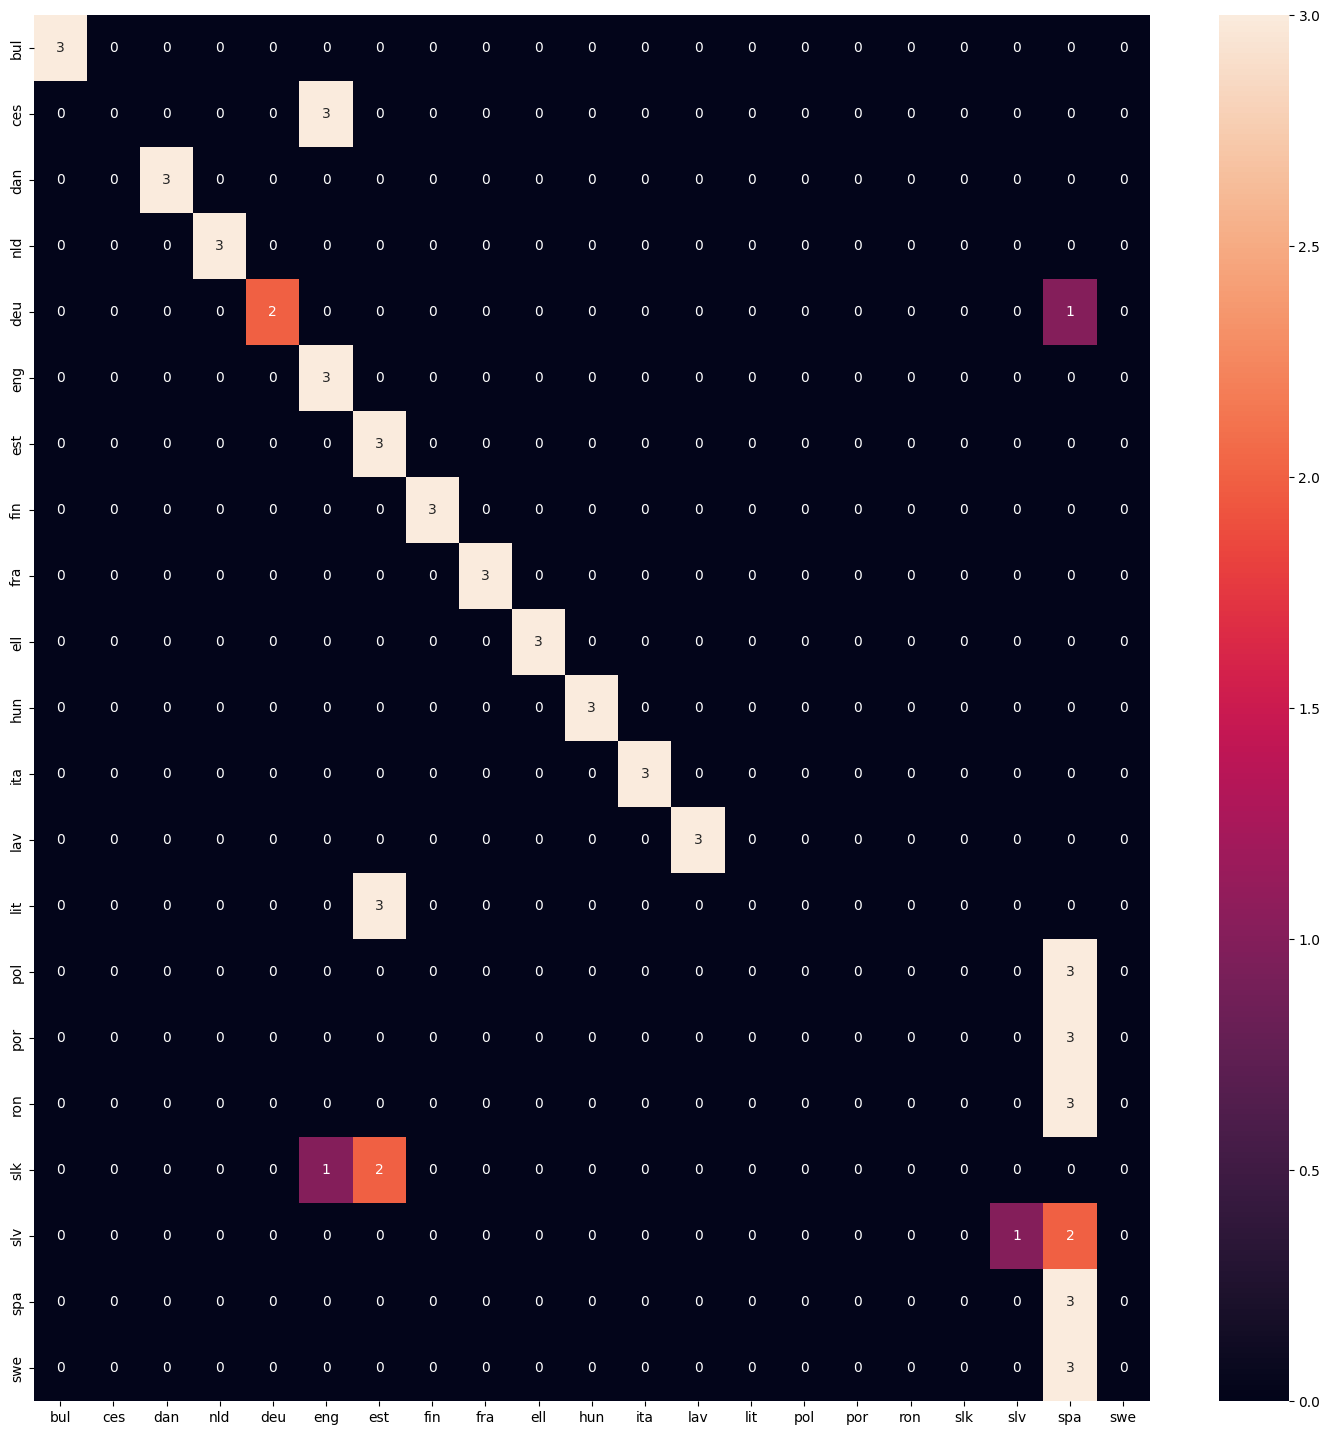

In [46]:
conf_mat= sklearn.metrics.confusion_matrix(GT, PR, labels=None, sample_weight=None)
Labels_arr = ['bul', 'ces', 'dan', 'nld', 'deu', 'eng', 'est', 'fin', 'fra',
       'ell', 'hun', 'ita', 'lav', 'lit', 'pol', 'por', 'ron', 'slk',
       'slv', 'spa', 'swe']
#plot confusion matrix
%matplotlib inline
df_cm = pd.DataFrame(conf_mat, index = [i for i in Labels_arr], columns = [j for j in Labels_arr])
plt.figure(figsize = (18,18))
sn.heatmap(df_cm, annot=True)

    dimension = 1000 

In [96]:
# accuracy and F1-Score
from sklearn.metrics import f1_score
acc=0.0
for i in range(len(GT)):
   acc+=(PR[i]==GT[i])
F1_Score = f1_score(GT, PR, average='weighted')
acc=acc/len(GT) 
print(f"The accuracy of the language detection algorithm using fixed size hd encoding of N_GRAMS with dimension\
 {hd_dimension}, is {100*acc}%, while the F1-Score is {F1_Score}")

The accuracy of the language detection algorithm using fixed size hd encoding of N_GRAMS with dimension 1000, is 82.53968253968253%, while the F1-Score is 0.7880024737167595


<Axes: >

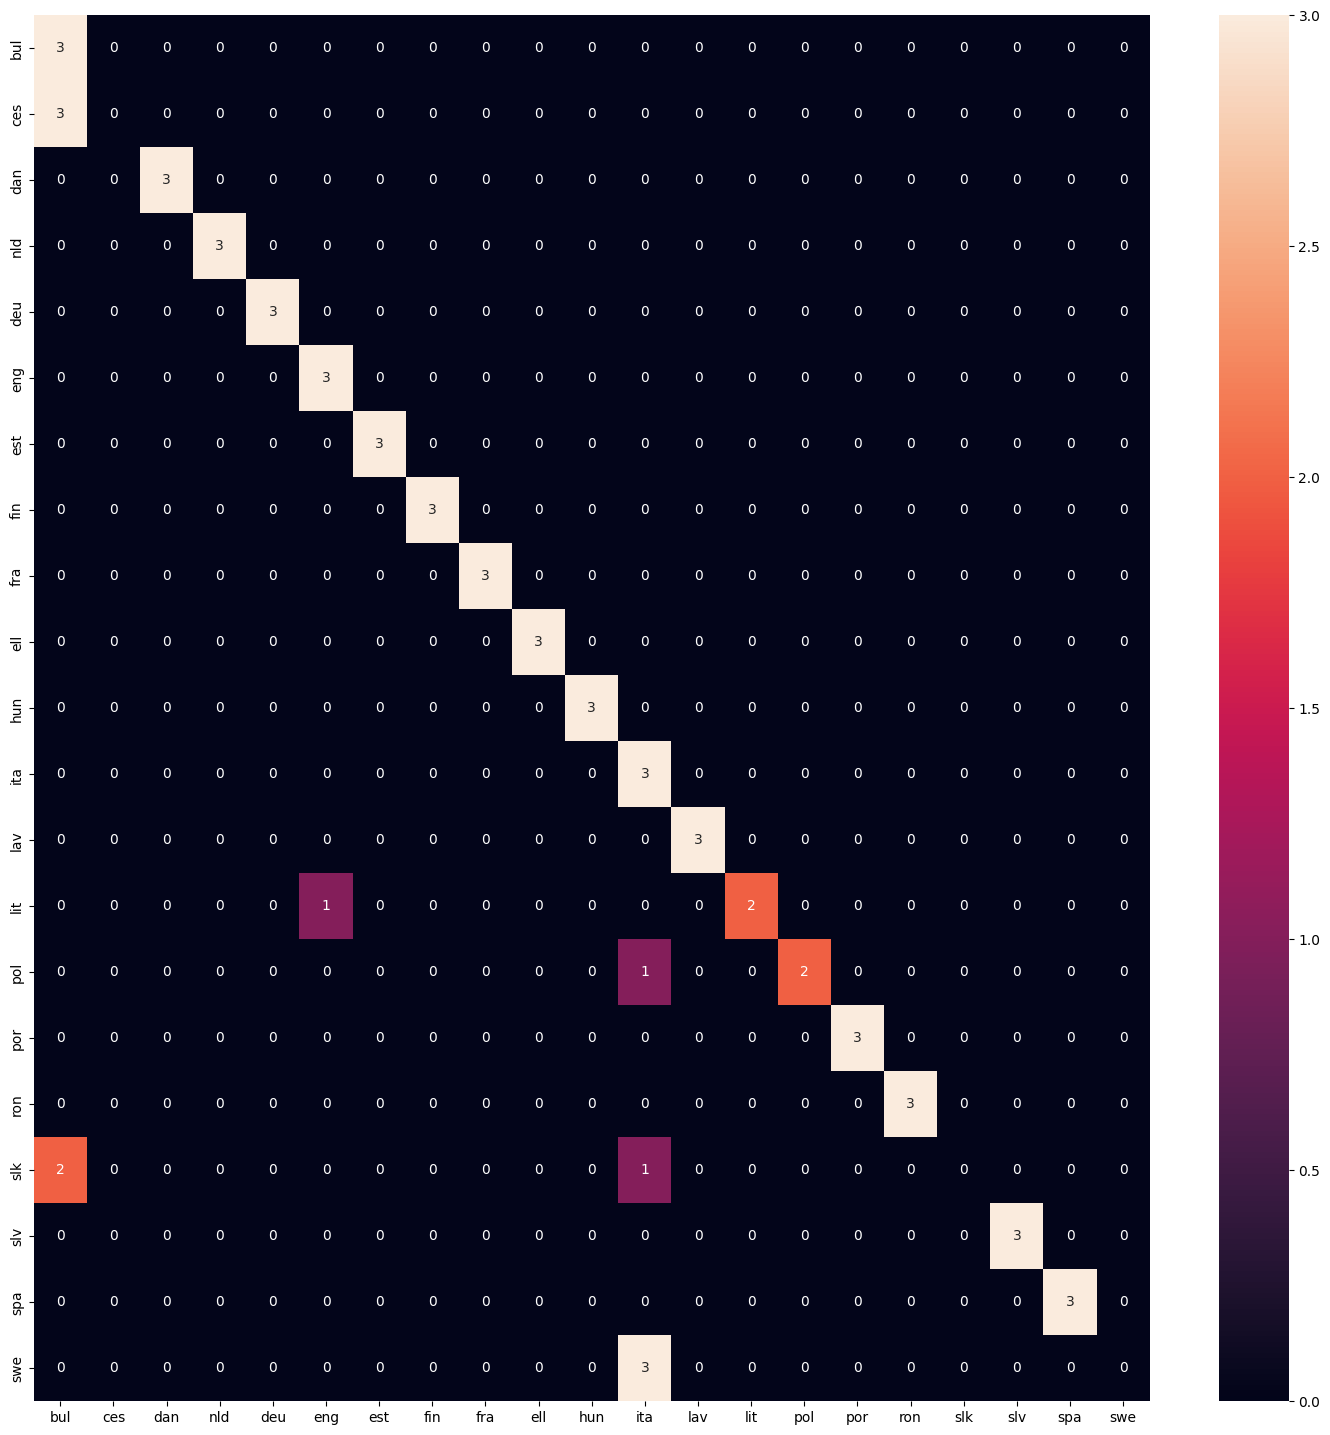

In [97]:
conf_mat= sklearn.metrics.confusion_matrix(GT, PR, labels=None, sample_weight=None)
Labels_arr = ['bul', 'ces', 'dan', 'nld', 'deu', 'eng', 'est', 'fin', 'fra',
       'ell', 'hun', 'ita', 'lav', 'lit', 'pol', 'por', 'ron', 'slk',
       'slv', 'spa', 'swe']
#plot confusion matrix
%matplotlib inline
df_cm = pd.DataFrame(conf_mat, index = [i for i in Labels_arr], columns = [j for j in Labels_arr])
plt.figure(figsize = (18,18))
sn.heatmap(df_cm, annot=True)